In [2]:
import pandas as pd
from models import batch_car_calculator

In [3]:
# 把证券代码添加进来
df_raw_CAR = pd.read_excel("./data/processed/股份回购与分红合并_添加Treat_Post.xlsx", skiprows=[1], dtype={"SCode_回购":str})
df_industry = pd.read_excel("./data/raw/公司行业分类.xlsx", dtype={"股票代码":str})

print(f"原始数据行数: {len(df_raw_CAR)}")
print(f"行业分类数据行数: {len(df_industry)}")

# 检查重复
print(f"df_industry 中 股票代码 重复数: {df_industry['股票代码'].duplicated().sum()}")

# 重新开始，避免重复合并
df_CAR = df_raw_CAR.copy()

# 第二次合并：添加证券代码（去重后合并）
df_industry_unique = df_industry.drop_duplicates(subset=['股票代码'], keep='first')
print(f"去重后的行业数据: {len(df_industry_unique)} 行")

df_CAR = pd.merge(df_CAR, df_industry_unique[['证券代码','股票代码']], 
                  left_on='SCode_回购', right_on='股票代码', how='left').drop(columns=['股票代码'])
print(f"合并证券代码后: {len(df_CAR)} 行")

# 验证最终数据
if len(df_CAR) != len(df_raw_CAR):
    print(f"\n⚠️ 警告: 最终行数 ({len(df_CAR)}) 与原始行数 ({len(df_raw_CAR)}) 不一致！")
else:
    print(f"\n✓ 合并成功，行数一致: {len(df_CAR)} 行")
df_CAR.to_excel("./data/interim/CAR.xlsx", index=False)
# 检查数据
print(f"\n数据预览:")
df_CAR.head(5)

原始数据行数: 11464
行业分类数据行数: 5177
df_industry 中 股票代码 重复数: 1
去重后的行业数据: 5176 行
合并证券代码后: 11464 行

✓ 合并成功，行数一致: 11464 行

数据预览:

数据预览:


,SCode_回购,BPAmtDy,SoAmDAD,RepMaNum,RepMiNum,RepType,RepProc,MaxPrc,MinPrc,AvePrc,...,EqBenmk,EqBenmkDt,AnnDt,RecordDt,DRDt,DPRDt,BnsShrLDt,Treat,Post,证券代码
0,000002,2015-07-06,2015-09-01,12480299.0,12480299.0,普通回购,实施完成,1.000000e+10,NaN,12.83,...,1.103915e+06,2016-07-28,2016-07-22,2016-07-28,2016-07-29,2016-07-29,NaN,1,0,000002.SZ
1,000002,2022-03-31,NaN,136836344.0,109469075.0,普通回购,实施中,2.500000e+09,2.000000e+09,17.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,000002.SZ
2,000004,2021-05-27,NaN,9049599.0,9049599.0,普通回购,完成实施,1.000000e+00,1.000000e+00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,000004.SZ
3,000004,2022-04-30,2022-05-21,23155018.0,23155018.0,普通回购,股东大会通过,1.000000e+00,1.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,000004.SZ
4,000004,2023-04-29,2023-05-20,939474.0,939474.0,普通回购,实施中,1.000000e+00,1.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,000004.SZ


In [4]:
# 随机抽样测试 CAR 计算

df_CAR_sample = df_CAR
# 随机抽样 100 行
# sample_size = 50
# df_CAR_sample = df_CAR.sample(n=min(sample_size, len(df_CAR)), random_state=42).copy()
# print(f"抽样测试: {len(df_CAR_sample)} 行")




In [5]:
from models import BatchCARCalculator
import os

calculator = BatchCARCalculator(
    df=df_CAR_sample, 
    estimation_window=(-120, -30),
    event_window=(-5, 5)
)

# 运行计算
print("开始批量计算...")
df_result = calculator.run()

# 保存结果
output_path = "./data/processed/CAR_sample_result.xlsx"
df_result.to_excel(output_path, index=False)
print(f"计算完成，结果已保存至: {output_path}")



Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.
开始批量计算...
Step 1: 获取市场数据...
使用缓存的市场指数数据
Step 2: 获取个股数据 (Wind)...
Processing row 0/11464
Processing row 100/11464
Processing row 200/11464
Processing row 300/11464
Processing row 400/11464
Processing row 500/11464
Processing row 600/11464
Processing row 700/11464
Processing row 800/11464
Processing row 900/11464
Processing row 1000/11464
Processing row 1100/11464
Processing row 1200/11464
Processing row 1300/11464
Processing row 1400/11464
Processing row 1500/11464
Processing row 1600/11464
Processing row 1700/11464
Processing row 1800/11464
Processing row 1900/11464
Processing row 2000/11464
Processing row 1000/11464
Processing row 1100/11464
Processing row 1200/11464
Processing row 1300/11464
Processing row 1400/11464
Processing row 1500/11464
Processing r

d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car

Step 4: 整合结果...
计算完成，结果已保存至: ./data/processed/CAR_sample_result.xlsx
计算完成，结果已保存至: ./data/processed/CAR_sample_result.xlsx


array([[<Axes: title={'center': 'CAR'}>]], dtype=object)

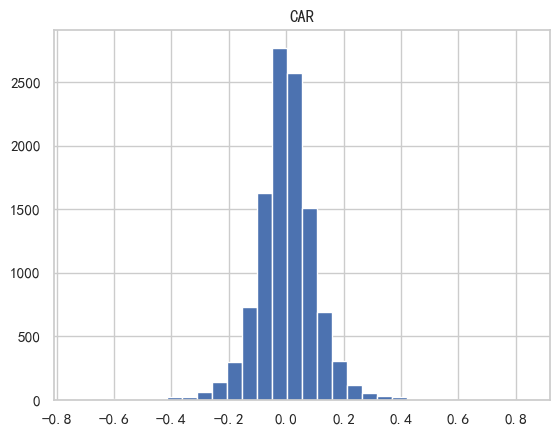

In [ ]:
df_result.head(5)
from matplotlib import pyplot as plt

df_result[['CAR']].hist(bins=30, )

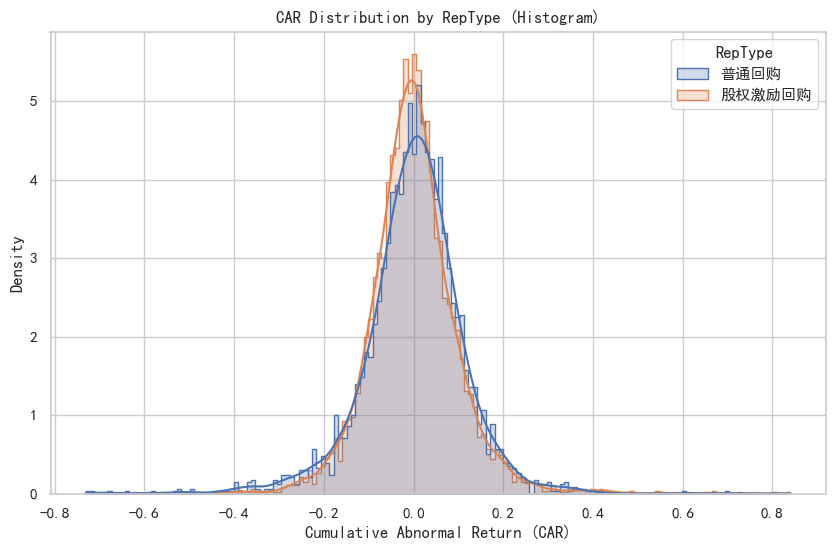

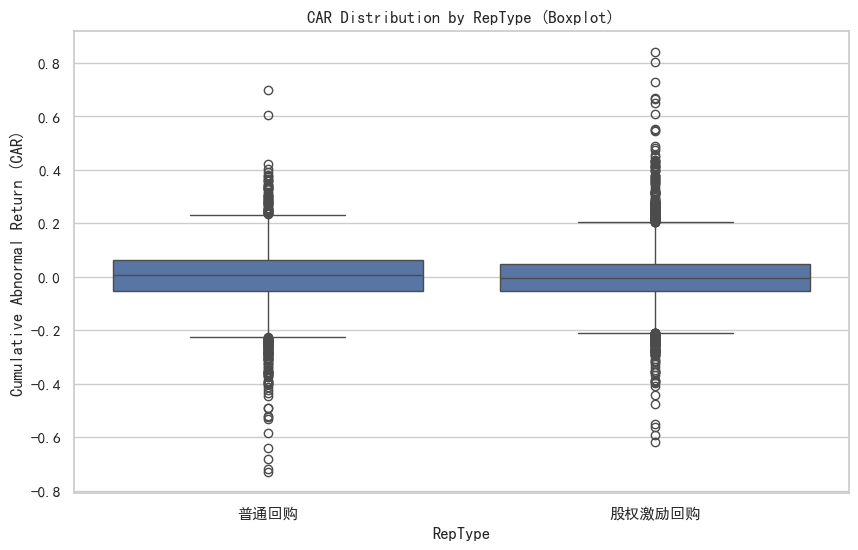

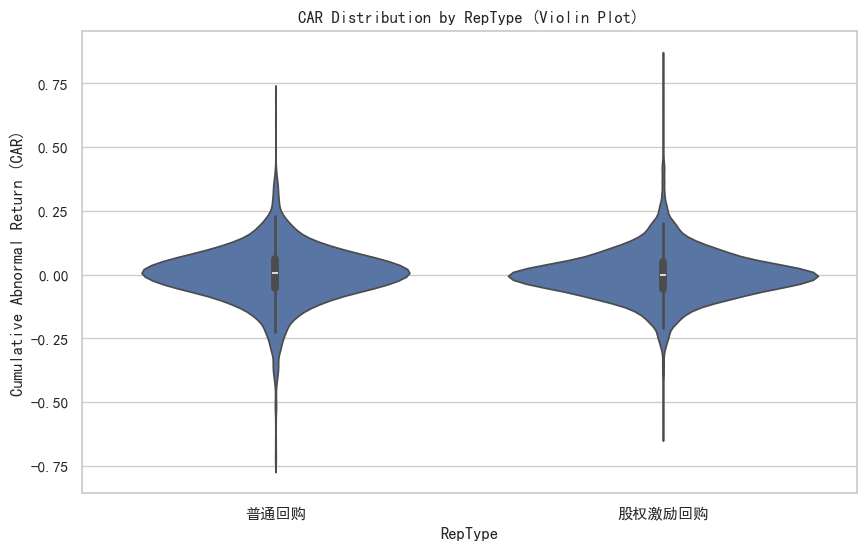

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 1. 直方图 (Histogram) - 重叠展示
plt.figure(figsize=(10, 6))
sns.histplot(data=df_result, x='CAR', hue='RepType', element="step", stat="density", common_norm=False, kde=True)
plt.title('CAR Distribution by RepType (Histogram)')
plt.xlabel('Cumulative Abnormal Return (CAR)')
plt.ylabel('Density')
plt.show()

# 2. 箱线图 (Boxplot) - 对比展示
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_result, x='RepType', y='CAR')
plt.title('CAR Distribution by RepType (Boxplot)')
plt.xlabel('RepType')
plt.ylabel('Cumulative Abnormal Return (CAR)')
plt.show()

# 3. 小提琴图 (Violin Plot) - 展示分布密度
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_result, x='RepType', y='CAR')
plt.title('CAR Distribution by RepType (Violin Plot)')
plt.xlabel('RepType')
plt.ylabel('Cumulative Abnormal Return (CAR)')
plt.show()

## 第二次算CAR


In [9]:
import pandas as pd
from models import batch_car_calculator
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [6]:
# 读取数据

df_raw = pd.read_excel("./data/processed/股份回购与分红合并_添加Treat_Post.xlsx", dtype={"Code":str}).iloc[:,1:]
print(df_raw.info())
df_raw.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   代码             14485 non-null  object        
 1   Code           14485 non-null  object        
 2   简称             14485 non-null  object        
 3   Year           14485 non-null  int64         
 4   最新公告日期         14485 non-null  datetime64[ns]
 5   回购进度           14485 non-null  object        
 6   首次公布完成日期       13548 non-null  datetime64[ns]
 7   回购方式           14485 non-null  object        
 8   回购目的           14485 non-null  object        
 9   已回购数量(股)       13877 non-null  float64       
 10  占总股本比例(%)      13877 non-null  float64       
 11  已回购金额(元)       13704 non-null  float64       
 12  回购均价           13693 non-null  float64       
 13  占公告回购总资金比例(%)  13676 non-null  float64       
 14  占公告回购总数量比例(%)  13863 non-null  float64       
 15  较最新收盘价涨跌幅(%)   1369

,代码,Code,简称,Year,最新公告日期,回购进度,首次公布完成日期,回购方式,回购目的,已回购数量(股),...,IEqTnRt,EqBenmk,EqBenmkDt,AnnDt,RecordDt,DRDt,DPRDt,BnsShrLDt,Treat,Post
0,000002.SZ,2,万科A,2022,2022-07-02,完成,2022-07-02,集中竞价交易,其他回购目的,72955992.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,000002.SZ,2,万科A,2016,2016-01-15,完成,2016-01-15,集中竞价交易,市值管理,12480299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,000004.SZ,4,*ST国华,2023,2023-07-27,实施,NaT,定向回购,盈利补偿,467726.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


C:\Users\fpy\AppData\Local\Temp\ipykernel_16616\1043660162.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


回购目的
股权激励注销           9097
实施股权激励或员工持股计划    1810
其他回购目的           1479
市值管理             1090
盈利补偿              541
实施股权激励            287
员工持股计划            131
维护公司价值及股东权益        39
转换公司可转债             9
重组                  2
Name: count, dtype: int64

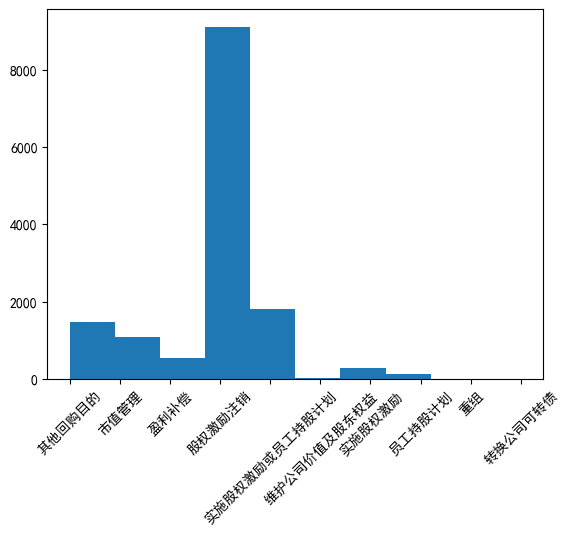

In [14]:
# 描述性统

fig, ax = plt.subplots()
ax.hist(df_raw["回购目的"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

df_raw["回购目的"].value_counts()

In [16]:
df_CAR = df_raw.copy()

In [18]:


calculator = batch_car_calculator.BatchCARCalculator(
    stock_col="代码",
    date_col="预案日",
    df=df_CAR,
    estimation_window=(-120, -30),
    event_window=(-5, 5)
)

df_result = calculator.run()

# 保存结果
output_path = "./data/processed/CAR_sample_result_new.xlsx"
df_result.to_excel(output_path, index=False)
print(f"计算完成，结果已保存至: {output_path}")

Step 1: 获取市场数据...
使用缓存的市场指数数据
Step 2: 获取个股数据 (Wind)...
Processing row 0/14485
Processing row 100/14485
Processing row 100/14485
Processing row 200/14485
Processing row 200/14485
Processing row 300/14485
Processing row 300/14485
Processing row 400/14485
Processing row 400/14485
Processing row 500/14485
Processing row 500/14485
Processing row 600/14485
Processing row 700/14485
Processing row 600/14485
Processing row 700/14485
Processing row 800/14485
Processing row 800/14485
Processing row 900/14485
Processing row 1000/14485
Processing row 900/14485
Processing row 1000/14485
Processing row 1100/14485
Processing row 1200/14485
Processing row 1100/14485
Processing row 1200/14485
Processing row 1300/14485
Processing row 1400/14485
Processing row 1500/14485
Processing row 1600/14485
Processing row 1700/14485
Processing row 1300/14485
Processing row 1400/14485
Processing row 1500/14485
Processing row 1600/14485
Processing row 1700/14485
Processing row 1800/14485
Processing row 1800/14485
Proc

d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car_calculator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = car / se_car
d:\学习资料\大创\大创项目代码\models\batch_car

Step 4: 整合结果...
计算完成，结果已保存至: ./data/processed/CAR_sample_result_new.xlsx
计算完成，结果已保存至: ./data/processed/CAR_sample_result_new.xlsx


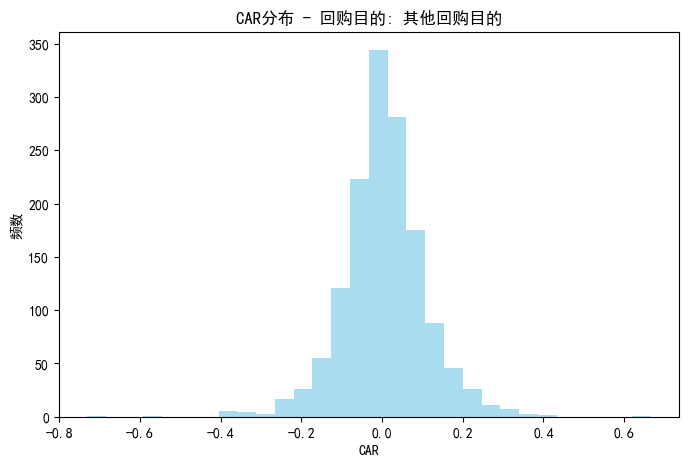

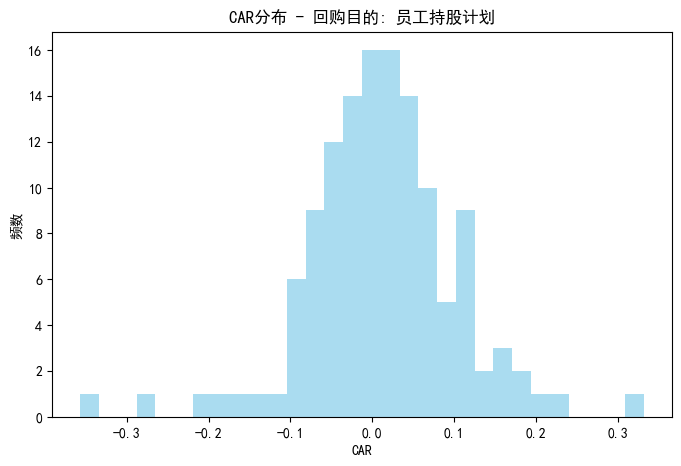

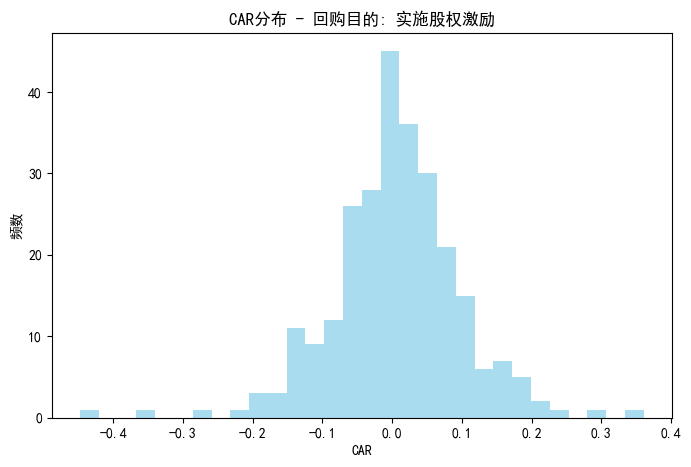

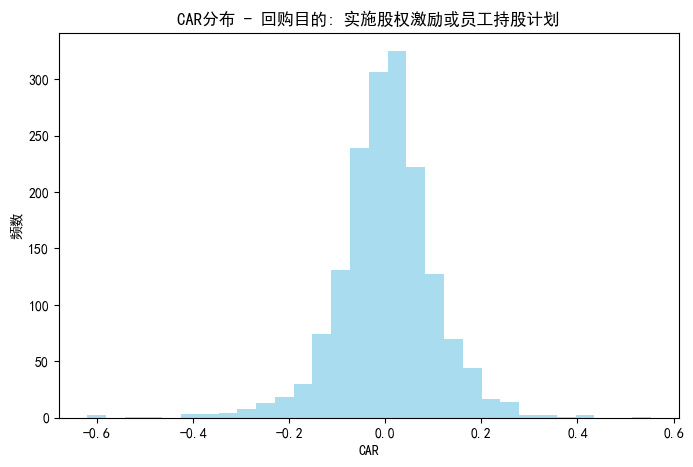

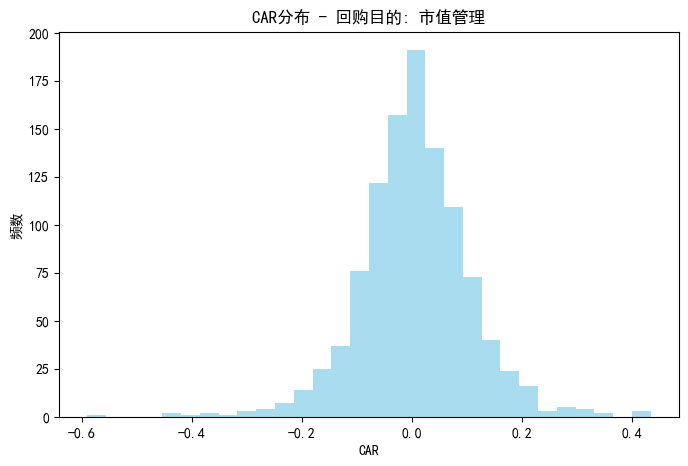

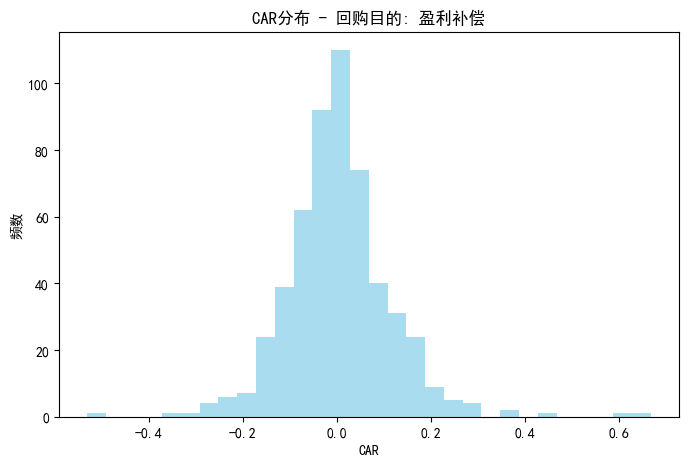

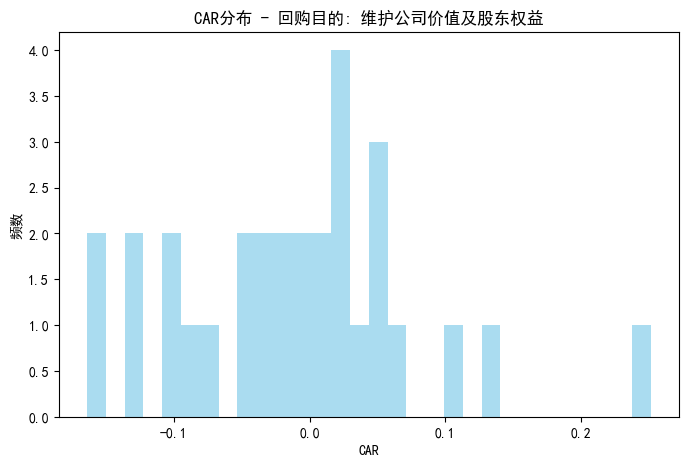

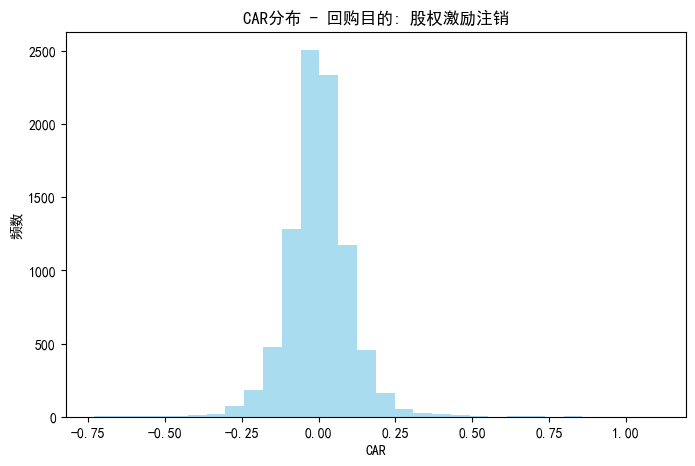

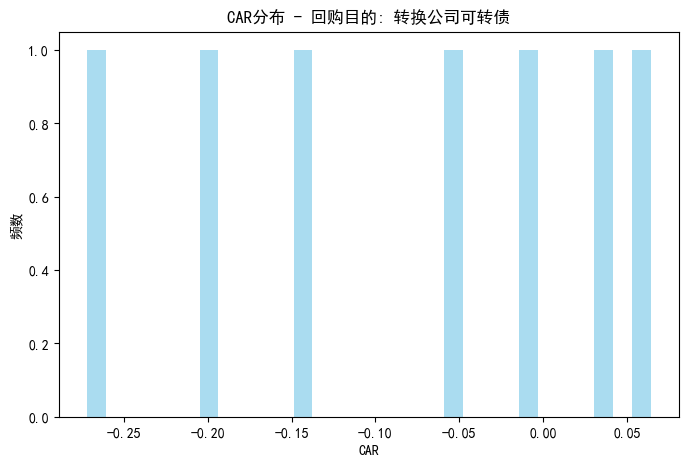

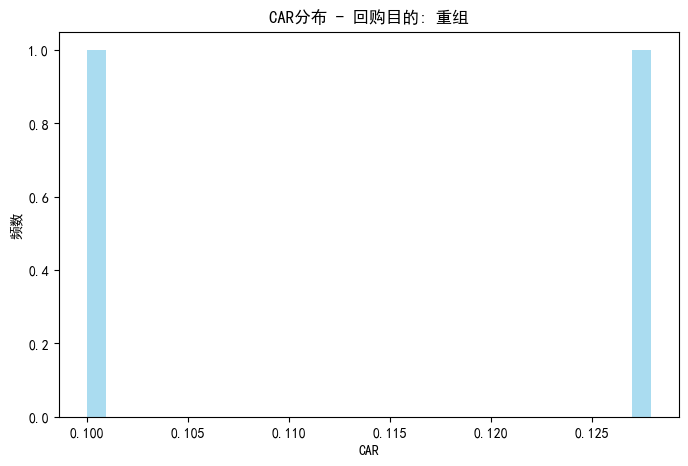

In [21]:
import matplotlib.pyplot as plt

group_col = '回购目的'  # 替换为你要分组的列名

for name, group in df_result.groupby(group_col):
    plt.figure(figsize=(8, 5))
    plt.hist(group['CAR'], bins=30, alpha=0.7, color='skyblue')
    plt.xlabel('CAR')
    plt.ylabel('频数')
    plt.title(f'CAR分布 - {group_col}: {name}')
    plt.show()